In [33]:
import numpy as np
import pandas as pd
from collections import defaultdict

from gensim import corpora, models
from gensim.models import CoherenceModel
from gensim.models.nmf import Nmf
from gensim.models.lsimodel import LsiModel
from gensim.models.ldamodel import LdaModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline

In [4]:
df = pd.read_pickle('tesla_clean.pkl')
df.reset_index(inplace=True)

In [8]:
documents = df['Discussion_Clean'].to_list()

In [19]:
stoplist = ['thank', 'lol', 'yes', 'nope', 'get', 'go', 'one', 'see', 'haha', 'nice', 'flag', 'spam', 'shit', 'here', 'look', 'use', 'good', 'say', 'think', 'know', 'nah', 'ah', 'time', 'fish', 'troll', 'nazi', 'ha', 'bye', 'ok', 'okay', 'fucking', 'andy', 'idiot', 'httpsteslatapcomarticlesownersmanualcompanionsearch', 'fishy', 'fishev', 'evil', 'tanya', 'lilbean', 'eaglespdx', 'lie', 'maxxer']

In [20]:
# remove common words and tokenize
texts = [
    [word for word in document.lower().split() if word not in stoplist]
    for document in documents
]

In [21]:
# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

In [22]:
texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

In [23]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
# step 1 -- initialize a model
tfidf = models.TfidfModel(corpus)

In [ ]:
corpus_tfidf = tfidf[corpus]

In [24]:
NUM_TOPICS = 8

In [25]:
def model_scoring (model, corpus, text, dictionary, perplex=False):

    # Compute Perplexity
    # a measure of how good the model is. lower the better.
    if perplex:
        print('Perplexity: ', model.log_perplexity(corpus))  

    # Compute Coherence Score
    coherence_model = CoherenceModel(model=model, 
                                         texts=text, 
                                         dictionary=dictionary, 
                                         coherence='c_v')
    
    coherence_lda = coherence_model.get_coherence()
    print('Coherence Score: ', coherence_lda)

In [27]:
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=NUM_TOPICS, random_state=42)

model_scoring(lda_model, corpus, texts, dictionary, perplex=True)

Perplexity:  -7.792065686997591
Coherence Score:  0.514033474322392


In [28]:
lsi_model = LsiModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)

model_scoring(lsi_model, corpus, texts, dictionary)

Coherence Score:  0.48751452592561456


In [29]:
nmf_model = Nmf(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary, random_state=42)

model_scoring(nmf_model, corpus, texts, dictionary)

Coherence Score:  0.5736083360372263


In [30]:
def compute_coherence_values(dictionary, corpus, texts, cohere, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=cohere)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [31]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus, 
                                                        texts=texts, 
                                                        cohere='c_v', # 'u_mass', 'c_v', 'c_uci', 'c_npmi'
                                                        start=2, 
                                                        limit=30, 
                                                        step=2)

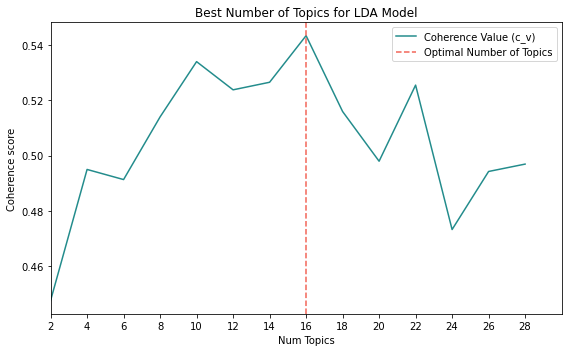

In [32]:
# Show graph
plt.figure(figsize=(8,5))

limit=30
start=2
step=2

x = range(start, limit, step)
ax = sns.lineplot(x=x, y=coherence_values, color='#238C8C')

# Set titles and labels
plt.title("Best Number of Topics for LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xlim(start, limit)
plt.xticks(range(2, limit, step))

# Add a vertical line to show the optimum number of topics
plt.axvline(x[np.argmax(coherence_values)], color='#F26457', linestyle='--')


# Draw a custom legend
legend_elements = [Line2D([0], [0], color='#238C8C', ls='-', label='Coherence Value (c_v)'),
                   Line2D([0], [1], color='#F26457', ls='--', label='Optimal Number of Topics')]

ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('topic_coherence.png', dpi=300)

In [37]:
NUM_TOPICS = 16

In [38]:
# Build LDA model
model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=NUM_TOPICS, random_state=42)

In [41]:
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(model, corpus, dictionary, sort_topics=True)

pyLDAvis.display(lda_viz)


In [ ]:
pyLDAvis.save_html(lda_viz, 'lda.html')